# Importing Libraries

In [36]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

#Uploading Dataset into Google Colab

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving images.zip to images.zip
User uploaded file "images.zip" with length 35434730 bytes


In [3]:
!unzip /content/images.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/train/NONE/NONE_584.png  
  inflating: images/images/train/NONE/NONE_585.png  
  inflating: images/images/train/NONE/NONE_586.png  
  inflating: images/images/train/NONE/NONE_587.png  
  inflating: images/images/train/NONE/NONE_588.png  
  inflating: images/images/train/NONE/NONE_589.png  
  inflating: images/images/train/NONE/NONE_59.png  
  inflating: images/images/train/NONE/NONE_590.png  
  inflating: images/images/train/NONE/NONE_591.png  
  inflating: images/images/train/NONE/NONE_592.png  
  inflating: images/images/train/NONE/NONE_593.png  
  inflating: images/images/train/NONE/NONE_594.png  
  inflating: images/images/train/NONE/NONE_595.png  
  inflating: images/images/train/NONE/NONE_596.png  
  inflating: images/images/train/NONE/NONE_597.png  
  inflating: images/images/train/NONE/NONE_598.png  
  inflating: images/images/train/NONE/NONE_599.png  
  inflating: images/images/train/NONE/NONE_6.png 

#Dataset Generation

In [37]:
train_path = 'images/images/train'
test_path = 'images/images/test'
valid_path = 'images/images/valid'

In [38]:
train_batches = ImageDataGenerator(rescale=1./255,zoom_range=0.2).flow_from_directory(train_path,target_size=(224,224),classes=['NONE','ONE','TWO','THREE','FOUR','FIVE'],batch_size=32)
test_batches = ImageDataGenerator(rescale=1./255,zoom_range=0.2).flow_from_directory(test_path,target_size=(224,224),classes=['NONE','ONE','TWO','THREE','FOUR','FIVE'],batch_size=32)
valid_batches = ImageDataGenerator(rescale=1./255,zoom_range=0.2).flow_from_directory(valid_path,target_size=(224,224),classes=['NONE','ONE','TWO','THREE','FOUR','FIVE'],batch_size=32)

Found 9081 images belonging to 6 classes.
Found 3632 images belonging to 6 classes.
Found 0 images belonging to 6 classes.


#Displaying Dataset Images

(32, 224, 224, 3) (32, 6)


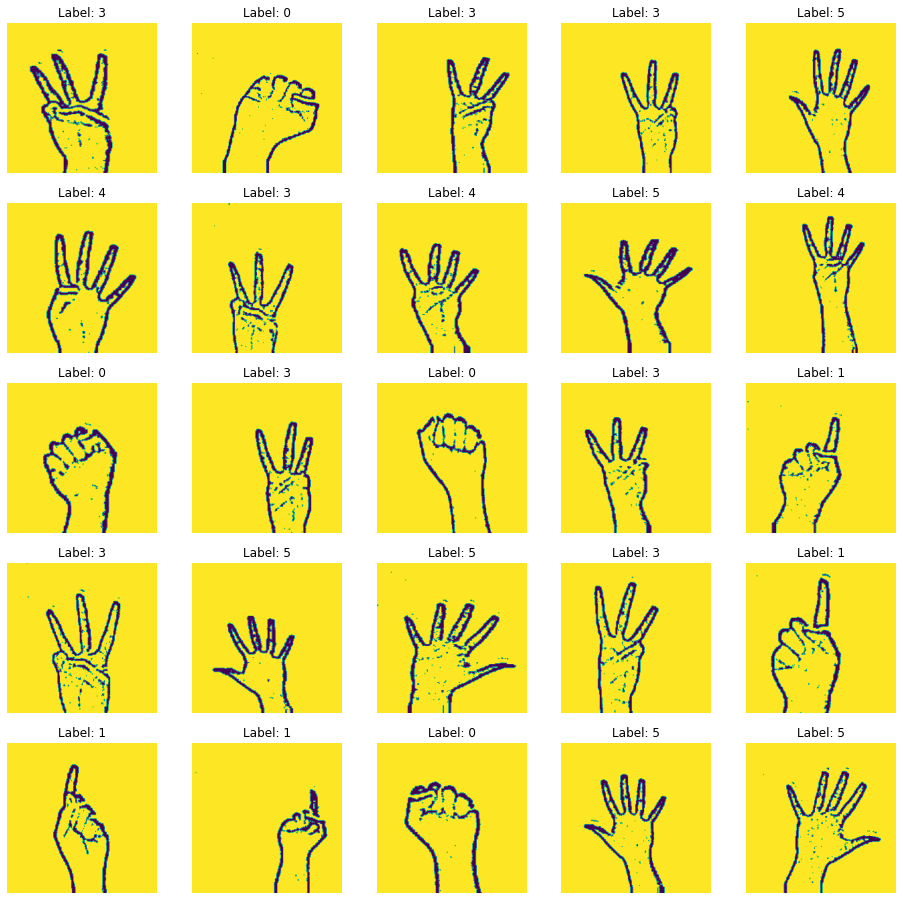

In [39]:
for X, y in train_batches:
    print(X.shape, y.shape)
    
    plt.figure(figsize=(16,16))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title('Label: %d' % np.argmax(y[i]))
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img)
    break

#Importing MobileNet v1 Model From Keras

In [42]:
mobile = keras.applications.mobilenet.MobileNet()

#Summary of Pre-Trained MobileNet Model

In [43]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

#Fine Tuning MobileNet Model for our dataset

In [44]:
x = mobile.layers[-6].output
predictions = Dense(6,activation='softmax')(x)

#Using the Fine-Tuned Model

In [45]:
model = Model(inputs=mobile.input, outputs=predictions)

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [47]:
for layer in model.layers[:-23]:
  layer.trainable = False

In [48]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

#Compiling Our Model

In [49]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Callback List

In [50]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='mobile_net_model_v1_0-5.h5', monitor='val_loss', save_best_only=True)]

#Training Our Model

In [51]:
history = model.fit_generator(train_batches, steps_per_epoch=64,validation_data=test_batches, validation_steps=28,epochs=10,callbacks=callbacks_list,verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
64/64 [==============================] - 193s 3s/step - loss: 0.3542 - accuracy: 0.8746 - val_loss: 1.2449 - val_accuracy: 0.6574
Epoch 2/10
64/64 [==============================] - 190s 3s/step - loss: 0.0235 - accuracy: 0.9889 - val_loss: 0.8446 - val_accuracy: 0.6942
Epoch 3/10
64/64 [==============================] - 190s 3s/step - loss: 0.0341 - accuracy: 0.9928 - val_loss: 0.1066 - val_accuracy: 0.9587
Epoch 4/10
64/64 [==============================] - 193s 3s/step - loss: 0.0167 - accuracy: 0.9943 - val_loss: 0.0263 - val_accuracy: 0.9933
Epoch 5/10
64/64 [==============================] - 191s 3s/step - loss: 0.0059 - accuracy: 0.9977 - val_loss: 0.2172 - val_accuracy: 0.9163
Epoch 6/10
64/64 [==============================] - 189s 3s/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.1582 - val_accuracy: 0.9587
Epoch 7/10
64/64 [==============================] - 191s 3s/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.3388 - val_accuracy: 0.8862
Epoch 8/10
64

#Saving Our Trained Model

In [52]:
model.save('mobile_net_model_v1_0-5.h5')

#Plotting The Training Curves

Text(0.5, 0, 'number of epochs')

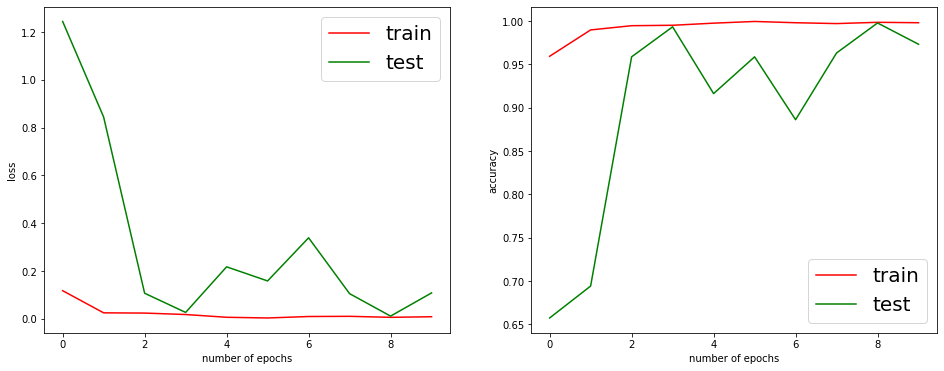

In [53]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'g-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('number of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['accuracy'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'g-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('number of epochs')

#Testing The Model

In [54]:
test_imgs,test_labels = next(test_batches)
test_labels

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0.

In [55]:
predictions = model.predict(test_imgs)
predictions

array([[1.04393436e-07, 1.43164675e-10, 1.25830326e-07, 5.14822379e-02,
        9.48099196e-01, 4.18361218e-04],
       [7.32552735e-07, 1.46446482e-08, 7.76568231e-06, 9.15822461e-02,
        8.36463571e-01, 7.19457269e-02],
       [9.99229312e-01, 4.86643956e-04, 4.13872694e-05, 2.37109824e-04,
        5.20632466e-06, 3.90629623e-07],
       [3.27419603e-09, 1.04317825e-08, 1.54938652e-06, 9.31876730e-06,
        4.41343407e-04, 9.99547780e-01],
       [9.99948978e-01, 2.31264112e-05, 2.06156460e-06, 2.29970901e-05,
        2.39233964e-06, 4.43247927e-07],
       [1.91874037e-13, 2.91975250e-10, 1.02642865e-03, 9.98973608e-01,
        8.16229528e-10, 8.59219806e-09],
       [2.45294948e-11, 4.89166138e-11, 6.16255802e-09, 3.90836306e-08,
        8.41173969e-05, 9.99915838e-01],
       [2.34081688e-13, 1.69858648e-13, 9.60674387e-11, 1.11006514e-07,
        1.14587874e-06, 9.99998689e-01],
       [3.79100029e-10, 9.99999046e-01, 9.16021634e-07, 2.94059399e-09,
        3.09324927e-11, 

#Displaying Testing Accuracy

In [56]:
X_test, y_test = [], []
for ibatch, (X, y) in enumerate(test_batches):
    X_test.append(X)
    y_test.append(y)
    ibatch += 1
    if (ibatch == 5*28): break
        
#Concatenate everything together
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
y_test = np.int32([np.argmax(r) for r in y_test])

#Get the predictions from the model and calculate the accuracy
y_pred = np.int32([np.argmax(r) for r in model.predict(X_test)])
match = (y_test == y_pred)
print('Testing Accuracy = %.2f%%' %(np.sum(match)*100/match.shape[0]))

Testing Accuracy = 97.58%


#Confusion Matrix

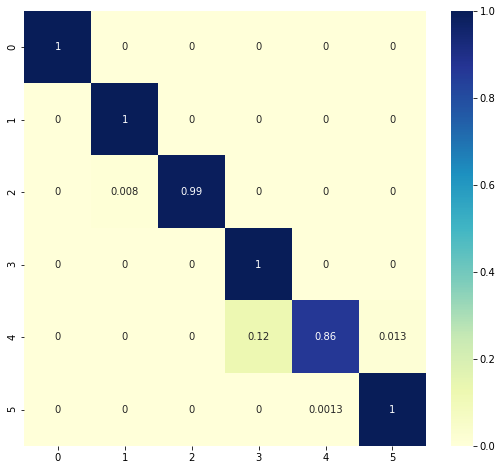

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(9,8))
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)
sns.heatmap(cm, annot=True, cmap="YlGnBu");

#Trying to Load Our Model But Some issues right now.

In [64]:
from keras.utils.generic_utils import CustomObjectScope
with CustomObjectScope({'relu6': keras.applications.mobilenet.relu6,'DepthwiseConv2D': keras.applications.DepthwiseConv2D}):
  Model = load_model('mobile_net_model_v1_0-5.h5')

AttributeError: ignored